# Idea 1
- We induce subgraph of proteins (or maybe subgraph of proteins + 1 degree of separation away)
- Find communities using MCL or Louvain to get us communities of size ~30
- Determine if these communities are functional
- Find bottlenecks/hub proteins of each complex
- This gives us relevant proteins for treatment or disrupting pathways

In [2]:
import networkx as nx
import numpy as np
import scipy as sp
import pandas as pd

In [3]:
# Reading in graph 
G = nx.read_weighted_edgelist("yeast.txt",comments="#",nodetype=str)

Removing edges not meeting threshold score. **Need to decide what we are doing with essential nodes.**

In [4]:
# Deleting edges that don't meet threshold score
threshold_score = 700
for edge in G.edges: 
    weight = list(G.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G.remove_edge(edge[0],edge[1])

Relabelling nodes to get rid of 4932 tag

In [5]:
H = nx.relabel_nodes(G, lambda x: x[5:])

Getting list of all yeast homologs

In [6]:
df = pd.read_csv("human_to_yeast.csv")
homologs = list(set(list(df["homolog_systematic_name"])))

Getting subgraph induced by yeast homologs

In [7]:
H0 = H.subgraph(homologs).copy()

In [8]:
print(H0)

Graph with 783 nodes and 4518 edges


Louvain

In [9]:
louvain = nx.algorithms.community.louvain_communities(H0, resolution=7, seed=123)
louvain.sort(key=len, reverse=True)

number_of_communities = len(louvain)
size_of_communities = [len(community) for community in louvain]

print("Number of communities: {}".format(number_of_communities))
print("Sizes of communities: ", size_of_communities)

Number of communities: 102
Sizes of communities:  [32, 25, 25, 23, 22, 21, 21, 21, 21, 20, 20, 19, 19, 18, 18, 18, 18, 17, 16, 16, 16, 15, 15, 15, 15, 15, 14, 14, 13, 13, 13, 13, 12, 12, 12, 12, 12, 12, 12, 11, 11, 10, 9, 5, 4, 4, 3, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Drawing communities (taking the t biggest communities)

In [10]:
import matplotlib.pyplot as plt
from netgraph import Graph
import random

c:\Users\amool\anaconda3\lib\site-packages\netgraph\_node_layout.py:1377: UserWarning: Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.
  warnings.warn("Graph contains a single community. Unable to compute a community layout. Computing spring layout instead.")
c:\Users\amool\anaconda3\lib\site-packages\netgraph\_edge_layout.py:785: RuntimeWarning: invalid value encountered in true_divide
  displacement = compatibility * delta / distance_squared[..., None]


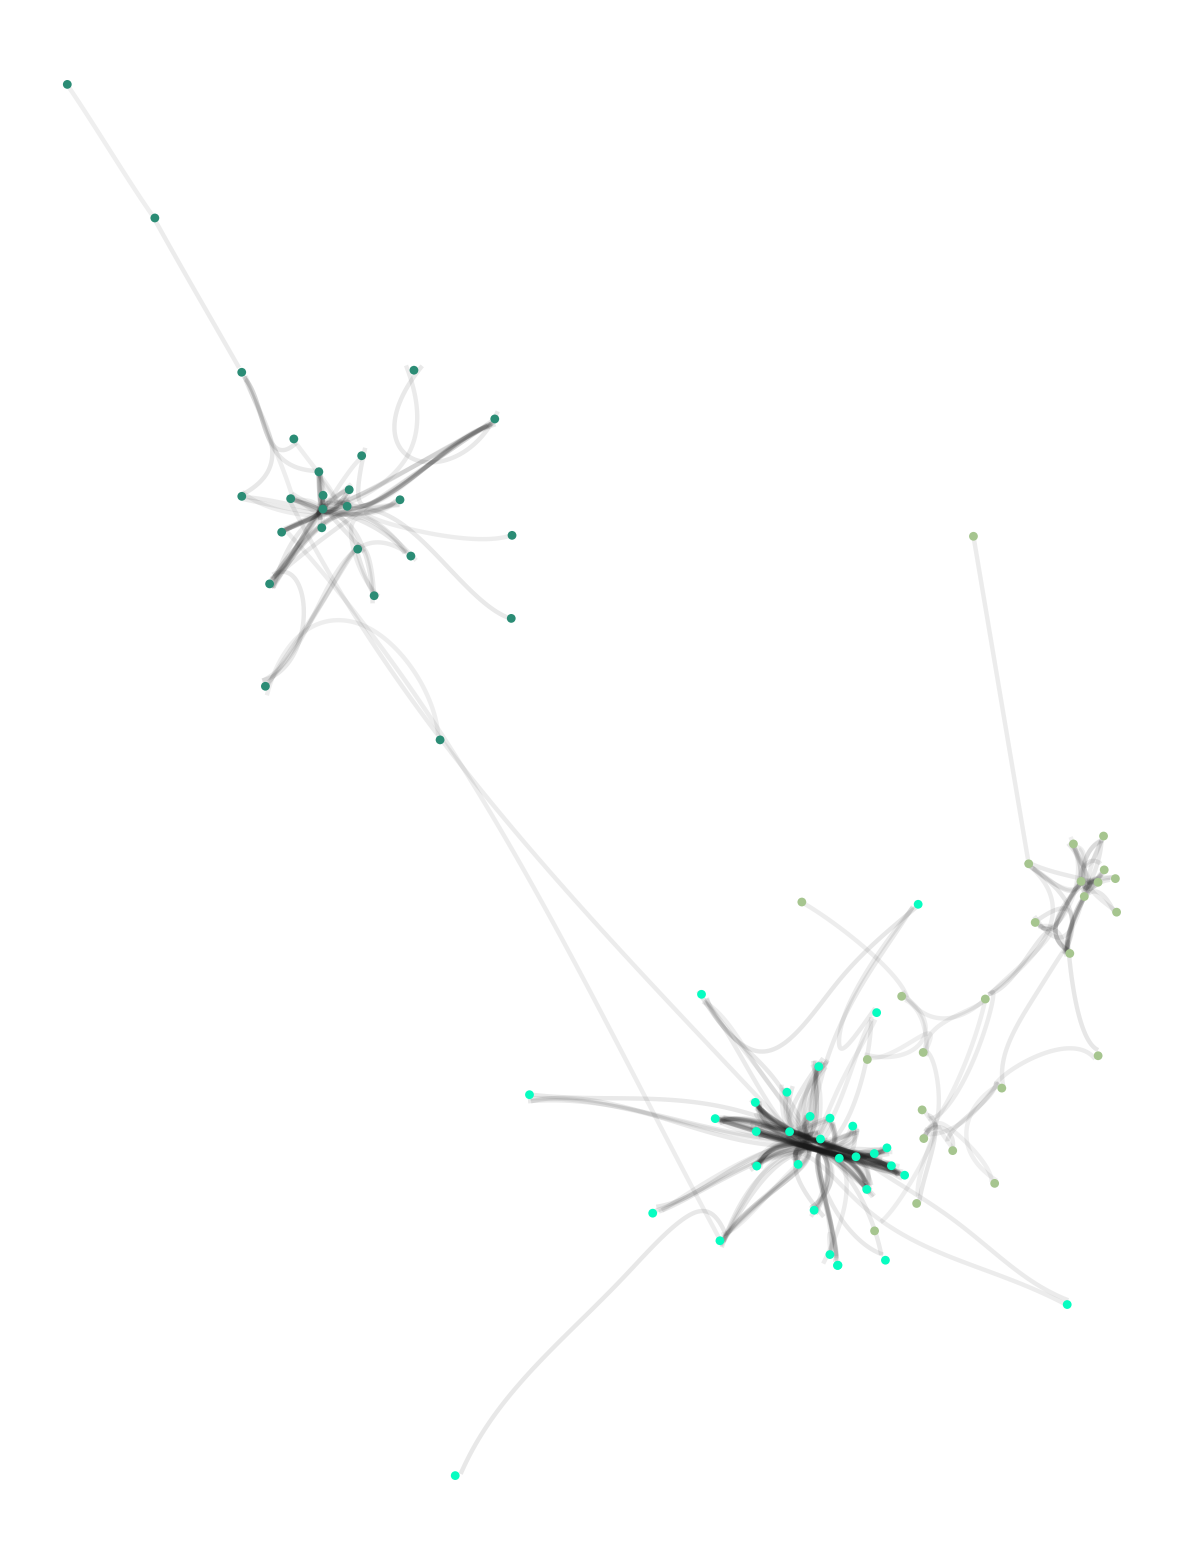

In [11]:
# parameter that controls how many communities we are interested in
t = 3

# Generating list of nodes of first t communities
nodes = []
for i in range(t):
  nodes.extend(louvain[i]) 


# Subgraph induced by these communities
H1 = H0.subgraph(nodes).copy()

# Dictionary where key is node and value is community index
node_to_community = {}
for i in range(t):
  for node in louvain[i]:
    node_to_community[node] = i

# Assigning t random colours each of our communities
community_to_color = dict([(i, "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])) for i in range(t)])
node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

plt.figure(figsize=(20,20))
Graph(H1,
      node_color=node_color, node_edge_width=0, edge_alpha=0.1, node_size = 0.5, edge_width = 0.5,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled', edge_layout_kwargs=dict(k=2000)
)

plt.show()

## Centrality

Degree Centrality

In [12]:
hub = {}
for index, community in enumerate(louvain):
  sub = H0.subgraph(community).copy()
  d = sorted(list(nx.algorithms.centrality.degree_centrality(sub).items()), key=lambda x: x[1], reverse=True)
  hub[index] = d[0]

print(hub)

{0: ('YMR105C', 0.6451612903225806), 1: ('YBL016W', 0.5416666666666666), 2: ('YER125W', 0.5416666666666666), 3: ('YDR091C', 0.5), 4: ('YBR247C', 0.9047619047619047), 5: ('YGL206C', 0.65), 6: ('YMR165C', 0.35000000000000003), 7: ('YIL061C', 0.8), 8: ('YOR261C', 1.0), 9: ('YNL189W', 0.631578947368421), 10: ('YER069W', 0.5789473684210527), 11: ('YDL132W', 1.0), 12: ('YLL013C', 0.7777777777777777), 13: ('YLR229C', 0.8235294117647058), 14: ('YML032C', 0.7058823529411764), 15: ('YJL034W', 1.0), 16: ('YFL038C', 0.8823529411764706), 17: ('YHR143W-A', 0.8125), 18: ('YML001W', 0.8), 19: ('YDL029W', 0.9333333333333333), 20: ('YPR183W', 0.4666666666666667), 21: ('YGR274C', 0.6428571428571428), 22: ('YGR209C', 0.5714285714285714), 23: ('YDL192W', 0.7857142857142857), 24: ('YGL202W', 0.3571428571428571), 25: ('YPL252C', 0.42857142857142855), 26: ('YPL240C', 0.6153846153846154), 27: ('YJR048W', 0.5384615384615385), 28: ('YLR378C', 0.5833333333333333), 29: ('YDR486C', 0.3333333333333333), 30: ('YMR217

Eigenvector Centrality

In [13]:
hub = {}
for index, community in enumerate(louvain):
  sub = H0.subgraph(community).copy()
  d = sorted(list(nx.algorithms.centrality.eigenvector_centrality(sub).items()), key=lambda x: x[1], reverse=True)
  hub[index] = d[0]

print(hub)

{0: ('YCR012W', 0.2841894943341416), 1: ('YBL016W', 0.37349157104696873), 2: ('YER125W', 0.430337778427571), 3: ('YHR020W', 0.3841623463268855), 4: ('YBR247C', 0.29775518052110783), 5: ('YGL206C', 0.34165693951016785), 6: ('YMR165C', 0.43192176150773787), 7: ('YIL061C', 0.29236104388876016), 8: ('YOR261C', 0.23132194958651595), 9: ('YNL189W', 0.3332976978910602), 10: ('YIL074C', 0.3500408003040037), 11: ('YDL132W', 0.37115514833312735), 12: ('YJL063C', 0.2854039270859411), 13: ('YLR229C', 0.3732324724010861), 14: ('YML032C', 0.3614725550233318), 15: ('YJL034W', 0.2834257477942101), 16: ('YPR181C', 0.31081714647459513), 17: ('YHR143W-A', 0.36883043179827335), 18: ('YML001W', 0.3651698225254561), 19: ('YDL029W', 0.3331702804140162), 20: ('YPR183W', 0.49475762401354373), 21: ('YGR274C', 0.41345816796249907), 22: ('YGR209C', 0.4133251269374297), 23: ('YDL192W', 0.41033962365046966), 24: ('YDR502C', 0.46572583147953384), 25: ('YPL252C', 0.4995502177836646), 26: ('YPL240C', 0.493797602866740

Betweenness Centrality

In [14]:
hub = {}
for index, community in enumerate(louvain):
  sub = H0.subgraph(community).copy()
  d = sorted(list(nx.algorithms.centrality.betweenness_centrality(sub).items()), key=lambda x: x[1], reverse=True)
  hub[index] = d[0]

print(hub)

{0: ('YMR105C', 0.25968759342273773), 1: ('YBL016W', 0.3565548079135035), 2: ('YER125W', 0.4212042788129744), 3: ('YDR091C', 0.46001855287569576), 4: ('YJL069C', 0.1565551776266062), 5: ('YNL106C', 0.20610896759442465), 6: ('YMR165C', 0.4105263157894737), 7: ('YBR257W', 0.09999999999999999), 8: ('YOR261C', 0.018224728487886383), 9: ('YOR112W', 0.29969367864104707), 10: ('YER069W', 0.404093567251462), 11: ('YDL132W', 0.18270308123249304), 12: ('YLL013C', 0.2697634609399315), 13: ('YHL007C', 0.14707633053221286), 14: ('YDR092W', 0.13122037276449042), 15: ('YJL034W', 0.10376427085985909), 16: ('YFL038C', 0.1480946545284781), 17: ('YHR143W-A', 0.2181196581196581), 18: ('YLR262C', 0.1570748299319728), 19: ('YLL050C', 0.10407407407407408), 20: ('YPR183W', 0.526984126984127), 21: ('YER164W', 0.22527472527472528), 22: ('YDR513W', 0.22252747252747254), 23: ('YDL192W', 0.27467294610151755), 24: ('YGL202W', 0.608058608058608), 25: ('YPL252C', 0.565934065934066), 26: ('YNL135C', 0.4337606837606836

VoteRank

In [15]:
print(nx.algorithms.centrality.voterank(H0, 10))

['YFL039C', 'YBR160W', 'YFL005W', 'YNL031C', 'YDL126C', 'YPL240C', 'YJL034W', 'YBR010W', 'YLR229C', 'YJL194W']


Creating graph of where each community is a node and the weight of edges between two communities A and B is equal to the number of communities between A and B.

In [85]:
# Assigning community index values to nodes
nx.set_node_attributes(H0, node_to_community, "community")

# Creating basic graph with all our communities as nodes, but no edges yet
F = nx.Graph()
F.add_nodes_from(range(0, number_of_communities))

for (u, v) in H0.edges:
  community_i = H0.nodes[u]["community"]
  community_j = H0.nodes[v]["community"]
  
  # if in different communities
  if community_i != community_j:
    
    # if community graph doesnt already have edge, we have to add the edge
    if not F.has_edge(community_i, community_j):
      F.add_edge(community_i, community_j, weight = 1)
    else:
      F[community_i][community_j]["weight"] += 1

Finding max weight (min weight is trivially 1)

In [88]:
max_weight = 1
for edge in F.edges:
  if F.edges[edge]["weight"] > max_weight:
    max_weight = F.edges[edge]["weight"]

print(max_weight)

54


Betweenness Centrality

Output below tells us that community 26 has the highest betweenness centrality (so it could be involved in many interactions etc.)

In [77]:
d = list(nx.algorithms.centrality.betweenness_centrality(F).items())
print(sorted(d, reverse=True, key=lambda x: x[1]))

[(26, 0.006128081388242931), (11, 0.005956647393892589), (62, 0.0057509605356140005), (9, 0.005575869654464511), (34, 0.00542774761860223), (22, 0.005071487174573954), (15, 0.005015697703203452), (14, 0.0048793637605518796), (41, 0.004753131061923938), (2, 0.004725761291979912), (35, 0.004319752559238505), (27, 0.004180502665651181), (4, 0.0040330022013190326), (12, 0.003721343562927721), (0, 0.003591828138857842), (38, 0.003521455421832456), (33, 0.0030237639148530237), (17, 0.003013621865367567), (28, 0.0029886408970567395), (16, 0.002634934097805385), (13, 0.0025120228043625644), (6, 0.0024460904881696967), (18, 0.0023482866505274013), (25, 0.0022819619874075324), (8, 0.00221494070442665), (5, 0.002177358120427428), (3, 0.001980778847115481), (7, 0.0019280972053249286), (1, 0.0018998981303567021), (40, 0.001893959705227829), (36, 0.001840304258881643), (43, 0.001838944588331524), (10, 0.0016687488238158012), (30, 0.0015691019651415694), (46, 0.00145483941957289), (37, 0.001437597961

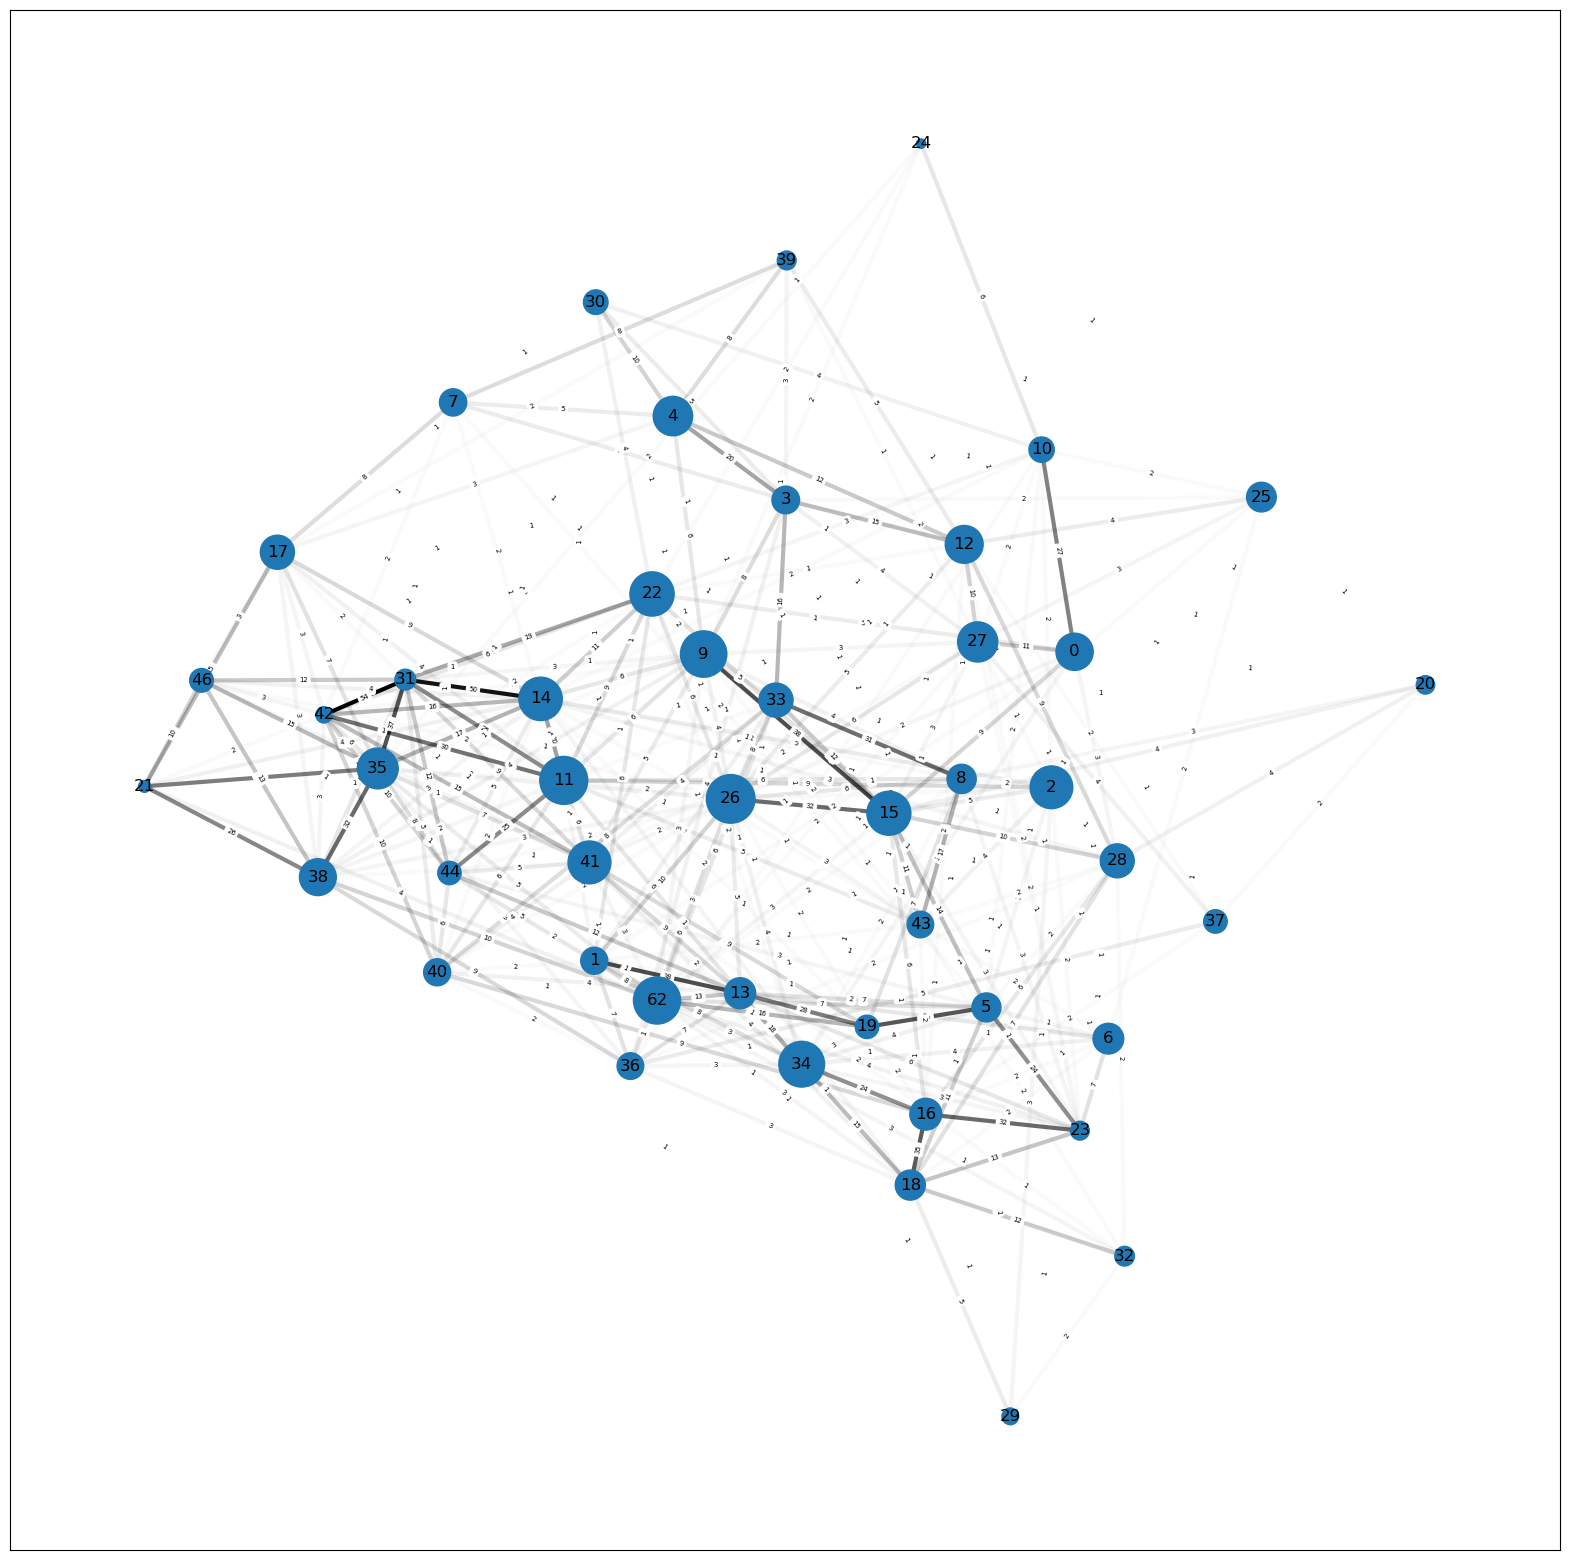

In [97]:
# Relating node sizes in the plot to how central the communities are (i.e. how large their betweenness centrality is).
# Note that communities with zero centrality disappear from the plot (aka communities which are not connected)
node_size = []
for i in range(len(d)):
  if d[i][1] != 0:
    node_size.append(d[i][1] * 200000)
nodelist = [node for (node, c) in d if c != 0]

# Relating edge opacity to weight.
edgelist = [(u, v) for (u, v) in F.edges if u in nodelist and v in nodelist]
edge_color = []
for edge in edgelist:
  # We normalise weight value so that it becomes between 0-1 for alpha values in RGBA
  edge_color.append((0, 0, 0, (F.edges[edge]["weight"] - 1) / (max_weight - 1)))

# Adding weight labels (bc why not, this is easily removed)
labels = nx.get_edge_attributes(F,'weight')

plt.figure(figsize=(20,20))
pos=nx.spring_layout(F)
nx.draw_networkx(F, pos, nodelist=nodelist, edgelist=edgelist, node_size=node_size, edge_color=edge_color, width=3)
nx.draw_networkx_edge_labels(F, pos, edge_labels=labels, font_size=5)
plt.show()